# Triplet decoherence in singlet fission

Singlet fission is a spin-allowed transition from a singlet state (spin-0) to a pair of triplet states (spin-1).

Here, we consider the decoherence process that follows singlet fission in a molecular dimer (two molecules, $A$ and $B$, bridged together or close enough to interact with each other) to study how correlations between the triplets are lost over time.

The Hamiltonian of the system is given by the **local** Zeeman ($\mathrm{Z}$) and zero-field splitting ($\mathrm{ZFS}$) terms and the isotropic triplet-triplet exchange interaction $H_\mathrm{ee}$:

$H = H_\mathrm{Z}^{(A)}\otimes\mathbb{1}+H_\mathrm{ZFS}^{(A)}\otimes\mathbb{1}+\mathbb{1}\otimes H_\mathrm{Z}^{(B)}+\mathbb{1}\otimes H_\mathrm{ZFS}^{(B)}+H_\mathrm{ee}$,

where:

- $S_x, S_y, S_x$ are the [spin-1 operators](https://en.wikipedia.org/wiki/Spin_(physics)#Higher_spins).
- $H_\mathrm{Z} = \omega_0 S_z/2$
- $H_\mathrm{ZFS} = \sum_{i,j = x,y,z} S_i \mathcal{D}_{ij} S_j$, where:
    - $\mathcal{D}_{ij}$ are the elements of the ZFS tensor $\mathcal{D} = R \mathcal{D}_0 R^{T}$,
    - $\mathcal{D}_0 = \mathrm{diag}(-D/3+E,-D/3-E,2D/3)$
    - $D$ and $E$ are the *axial* and *transversal* components of the magnetic dipole-diple interaction
    - $R$ is some rotation matrix
- $H_\mathrm{ee} = J_0 \sum_{i=x,y,z} S_i^{(A)}\otimes S_i^{(B)}$


## Import modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from diagnostics import density_matrix_positivity, trajectory_min_eigs
from plotting import style, plot_min_eig, plot_coherences, plot_populations
style()

## System Hamiltonian

Construct the system Hamiltonian for the following parameters:

- $\omega_0 = 2$
- $D = 1$
- $E = 3$
- $R_A = \mathbb{1} $ (rotation matrix for the molecule $A$)
- $R_B =$ Euler Rotation with angles $(90,45,30)$ (rotation matrix for the molecule $B$)
- $J_0 = 10$

The spin-1 operators $S_x$, $S_y$ and $S_z$ can be found [here](https://en.wikipedia.org/wiki/Spin_(physics)#Higher_spins). </br>
[Euler rotation matrices](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) can be constructed with the `spatial.transform` module of `scipy`.

In [2]:
# spin-1 operators using QuTiP
Sx = qt.jmat(1, 'x')
Sy = qt.jmat(1, 'y')
Sz = qt.jmat(1, 'z')
S = [Sx, Sy, Sz]

# import rotation matrices
from scipy.spatial.transform import Rotation as R

# function to get the Hamiltonian
def Hamiltonian(w0=1, D=1, E=1, J0=1, RA=np.eye(3), RB=np.eye(3)):
    # Zeeman term
    HzA = (w0 / 2) * Sz
    HzB = (w0 / 2) * Sz
    
    # Zero-field splitting term
    D0 = qt.Qobj(np.diag([-D/3 + E, -D/3 - E, 2*D/3]))
    HzfsA = qt.Qobj(RA) * D0 * qt.Qobj(RA.T)
    HzfsB = qt.Qobj(RB) * D0 * qt.Qobj(RB.T)
    
    # Exchange term
    Hee = J0 * (qt.tensor(Sx, Sx) + qt.tensor(Sy, Sy) + qt.tensor(Sz, Sz))
    
    # total Hamiltonian
    H = qt.tensor(HzA + HzfsA, qt.qeye(3)) + qt.tensor(qt.qeye(3), HzB + HzfsB) + Hee
    return H

# Zeeman frequency
w0 = 2

# ZFS parameters
D, E = 1, 3

# Rotation matrices for molecules A and B
RA = R.from_euler('zyx', [0, 0, 0], degrees=True).as_matrix()
RB = R.from_euler('zyx', [90, 45, 30], degrees=True).as_matrix()

# Exchange strength
J0 = 10

# Hamiltonian from parameters
H = Hamiltonian(w0, D, E, J0, RA, RB)

## Hamiltonian spectrum as a function of the Zeeman interaction strength

Calculate the Hamiltonian eigenvalues $\varepsilon_k$ as a function of $\omega_0 = [0,2J_0]$

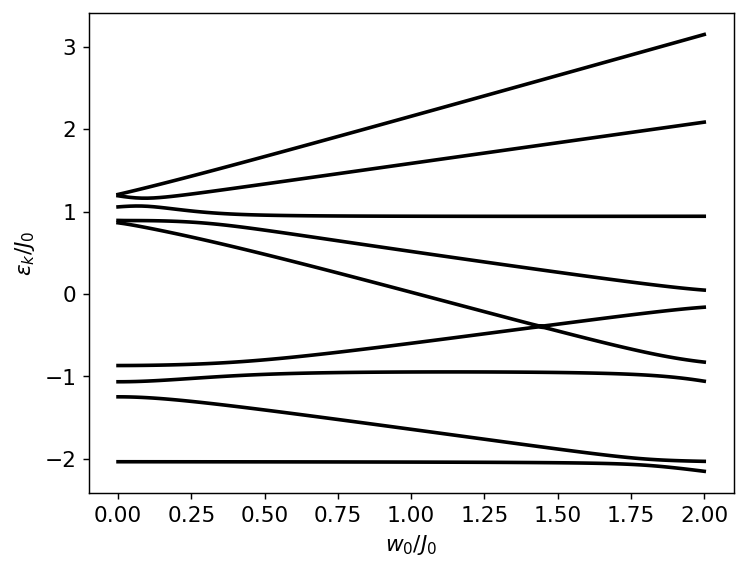

In [3]:
# Zeeman strength
w0s = np.linspace(0, 2*J0, 100)

# eigenvalues dataset
data = []

# iterate over w0
for w0 in w0s:
    # create the Hamiltonian
    temp = Hamiltonian(w0, D, E, J0, RA, RB)
    # eigenstates (sorted) of the Hamiltonian
    evals, _ = temp.eigenstates()
    evals = np.sort(evals)
    # append results in 
    data.append(evals)

# figure
fig, ax = plt.subplots()
# plot eigenstates
for evals in np.array(data).T:
    ax.plot(w0s/J0, evals/J0, 'k-');
ax.set_xlabel(r'$w_0$/$J_0$');
ax.set_ylabel(r'$\varepsilon_k$/$J_0$');

## Singlet, triplet, and quintets

Singlet, triplet, and quintet states are defined as the simultaneous eigenstates of local $S_z$ (Zeeman term) and total $S^2 = S_x\otimes S_x+S_y\otimes S_y+ S_z\otimes S_z$ (exchange) operators. For strong exchange and intermediate Zeeman interactions, the states are ordered as:
- singlet ($S=0,m=0$),
- triplets ($S=1,m=-1,0,1$), and
- quintets ($S=2,m=-2,-1,0,1,2$)

where $(S,m)$ are the total and z-component of the spin operator.

- Calculate these states using $J_0 = 10\omega_0$, setting $D,E = 0$.
- Calculate the singlet, triplet, and quintet components for each eigenstate of the total Hamiltonian using the initial parameters.

To calculate sorted eigenvalues and eigenvectors, you can use the `eigensorter` method in `tools`.

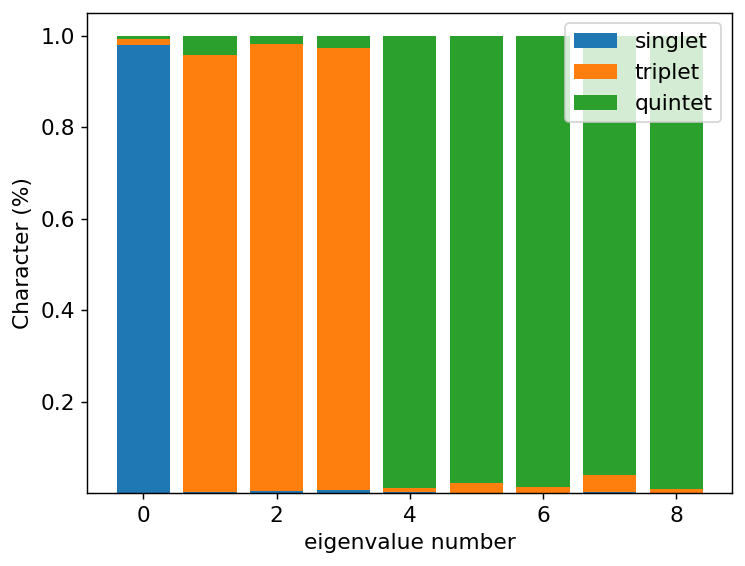

In [5]:
# strong exchange and intermediate Zeeman interactions
W0 = 1
Q = Hamiltonian(w0=w0, J0=10*w0, D=0, E=0)
_, TT = Q.eigenstates()

# define singlets, triplets, and quintets
singlets = TT[0:1]
triplets = TT[1:4]
quintets = TT[4:]

# function to calculate the spin character
def character(state, character=singlets):
    operator = sum([ket * ket.dag() for ket in character])
    if isinstance(state, qt.Qobj):
        if state.isket:
            return qt.expect(operator, state)
        else:
            return (operator * state).tr()
    else:
        # fallback for numpy
        operator_np = operator.full()
        if len(state.shape) == 1:
            return np.real(state.conj().T @ operator_np @ state)
        else:
            return np.trace(operator_np @ state)

# calculate the singlet character of some eigenstate of H
evals, evecs = H.eigenstates()

# figure
fig, ax = plt.subplots()
si = np.array([character(psi, character=singlets) for psi in evecs])
tr = np.array([character(psi, character=triplets) for psi in evecs])
qu = np.array([character(psi, character=quintets) for psi in evecs])
ax.bar(range(len(evecs)), si, label='singlet')
ax.bar(range(len(evecs)), tr, bottom=si, label='triplet')
ax.bar(range(len(evecs)), qu, bottom=si+tr, label='quintet')
ax.set_xlabel('eigenvalue number');
ax.set_ylabel('Character (%)')
ax.legend();

## Decoherence

Assume that the dynamics are generated by the total Hamiltonian $H$ and some **local** depolarisation mediated by the following Lindblad operators:

- $\sqrt{\gamma}\: S_x\otimes\mathbb{1}$
- $\sqrt{\gamma}\: S_y\otimes\mathbb{1}$
- $\sqrt{\gamma}\: S_z\otimes\mathbb{1}$
- $\sqrt{\gamma}\: \mathbb{1}\otimes S_x$
- $\sqrt{\gamma}\: \mathbb{1}\otimes S_y$
- $\sqrt{\gamma}\: \mathbb{1}\otimes S_z$

where $\gamma$ is some depolarisation rate.

Propagate an initial pure singlet state $|\psi_0\rangle = |S=0,m=0\rangle =:|0,0\rangle$ (using a short-hand notation) and calculate the population of the **triplets** as a function of time:

$p_1(t) = \mathrm{Tr}[\rho(t)\Pi_1]$, where $\Pi_1 = |1,-1\rangle\langle 1,-1|+|1,0\rangle\langle 1,0|+|1,1\rangle\langle 1,1|$.

Use the following values for the propagation:
- $\gamma = w0/10$
- $t_f = 10J_0$
- $dt = w0/100$

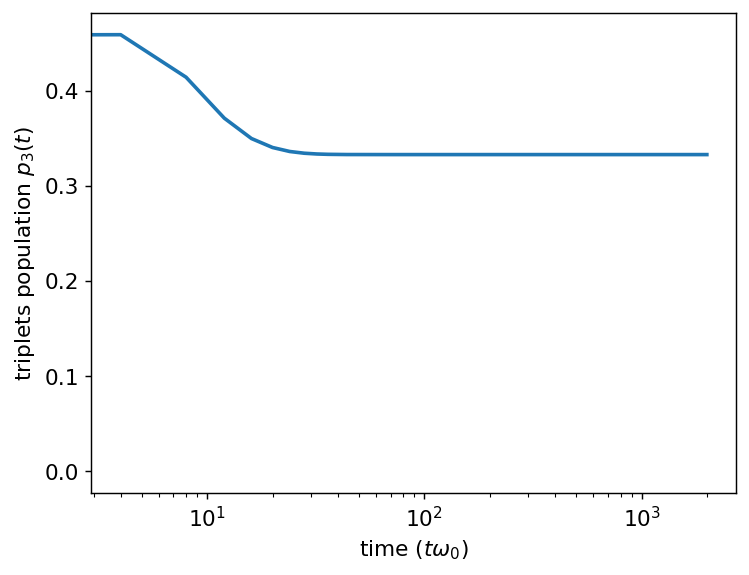

In [7]:
# initial state
rho0 = singlets[0] * singlets[0].dag()

# decoherence rate
gamma = w0 / 10

# Lindblad operators
c_ops = [np.sqrt(gamma) * qt.tensor(Sk, qt.qeye(3)) for Sk in S] + [np.sqrt(gamma) * qt.tensor(qt.qeye(3), Sk) for Sk in S]

# times and timestep
tf = 10 * J0
dt = w0 / 100
times = np.arange(0, tf, dt)

# solve using QuTiP mesolve
result = qt.mesolve(H, rho0, times, c_ops=c_ops, options={"store_states": True})

# results
data = [character(state, triplets) for state in result.states]

# figure
fig, ax = plt.subplots()
ax.plot(times * w0, data);
ax.set_xscale('log');
ax.set_xlabel(r'time ($t \omega_0$)');
ax.set_ylabel(r'triplets population $p_3(t)$');

## Entanglement decay and formation of uncorrelated triplets

We can now study the decay of correlations between triplets by measuring the *[negativity](https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics))* (an entanglement measure) $\mathcal{N}[\rho(t)]$ as a function of time, where:

$\mathcal{N}[\rho] := \frac{1}{2}(||\rho^{T_1}||_1-1)$, where
-  $||X||_1 = \text{Tr}|X| = \text{Tr} \sqrt{X^\dagger X}$
-  $\rho^{T_1}$ is the partial transpose with respect to system 1.

**Note**: $\mathcal{N}=0$ for separable states, $\mathcal{N}>0$ for entangled states.

c:\Users\leopo\anaconda3\envs\redfield\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


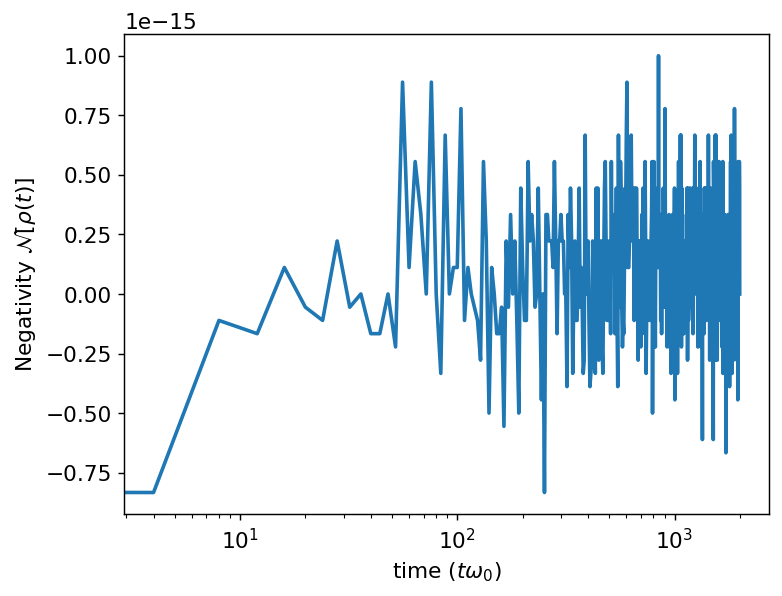

In [9]:
# results
data = [qt.negativity(state, [1]) for state in result.states]

# figure
fig, ax = plt.subplots()
ax.plot(times * w0, data);
ax.set_xscale('log');
ax.set_xlabel(r'time ($t \omega_0$)');
ax.set_ylabel(r'Negativity $\mathcal{N}[\rho(t)]$');

## Comparison between mesolve and brmesolve for depolarization

c:\Users\leopo\anaconda3\envs\redfield\Lib\site-packages\qutip\utilities.py:55: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


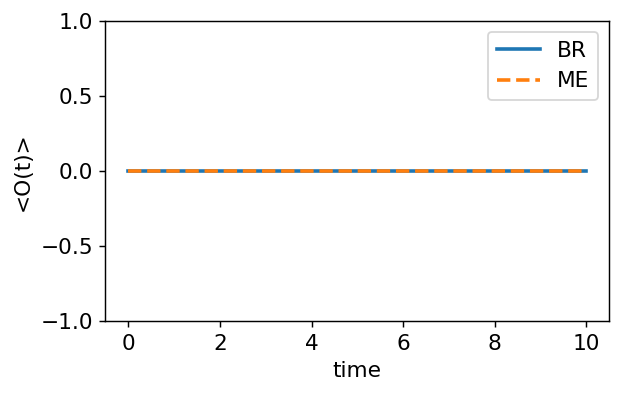

In [10]:
import qutip as qt

# rate
gamma = 0.01

# spin-1 operators
Sx = np.array([[0,1,0],[1,0,1],[0,1,0]])/np.sqrt(2)
Sy = np.array([[0,-1j,0],[1j,0,-1j],[0,1j,0]])/np.sqrt(2)
Sz = np.array([[1,0,0],[0,0,0],[0,0,-1]])

# Hamiltonian for single spin
H = Sz  # simple

# time span
t0, tf = 0, 10
steps = 200
times = np.linspace(t0, tf, steps)

# observable
O = Sx

# initial state |0>
psi = np.array([1,0,0])
rho = np.outer(psi, psi.conj())

# convert to qt
H_qt = qt.Qobj(H)
rho_qt = qt.Qobj(rho)
O_qt = qt.Qobj(O)

# bath for brmesolve
bath = qt.OhmicEnvironment(T=1e-3, wc=10.0, alpha=gamma, s=1.0)
a_ops = [[qt.Qobj(Sx), bath], [qt.Qobj(Sy), bath], [qt.Qobj(Sz), bath]]
c_ops = [np.sqrt(gamma) * qt.Qobj(Sx), np.sqrt(gamma) * qt.Qobj(Sy), np.sqrt(gamma) * qt.Qobj(Sz)]

# solve
result_decoh_br = qt.brmesolve(H=H_qt, psi0=rho_qt, tlist=times, a_ops=a_ops, e_ops=[O_qt], options={"store_states": True}, sec_cutoff=-1)
result_decoh_me = qt.mesolve(H=H_qt, rho0=rho_qt, tlist=times, c_ops=c_ops, e_ops=[O_qt], options={"store_states": True})
Ot_decoh_br = result_decoh_br.expect[0]
Ot_decoh_me = result_decoh_me.expect[0]

# plot
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(times, Ot_decoh_br, label="BR")
ax.plot(times, Ot_decoh_me, label="ME", ls='--')
ax.set_ylim([-1,1])
ax.set_xlabel('time')
ax.set_ylabel('<O(t)>')
ax.legend()

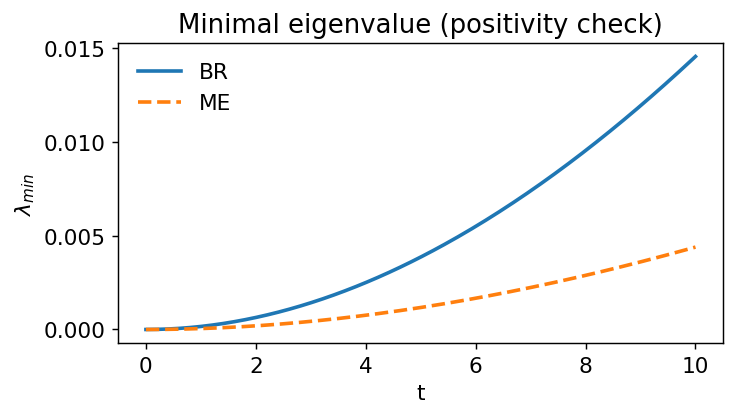

In [11]:
from diagnostics import trajectory_min_eigs

min_eigs_br = trajectory_min_eigs(result_decoh_br.states)
min_eigs_me = trajectory_min_eigs(result_decoh_me.states)
plt.figure(figsize=(6,3))
plt.plot(times, min_eigs_br, label='BR')
plt.plot(times, min_eigs_me, label='ME', ls='--')
plt.ylabel(r'$\lambda_{min}$')
plt.xlabel('t')
plt.legend(frameon=False)
plt.title('Minimal eigenvalue (positivity check)')
plt.show()

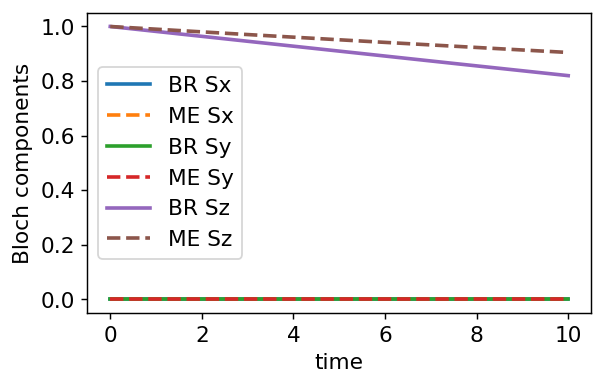

In [12]:
# get states for BR
states_decoh_br = result_decoh_br.states

# Bloch vectors for BR (for spin-1, generalized)
# For spin-1, Bloch vector is <Sx>, <Sy>, <Sz>
bloch_vectors_decoh_br = np.real(np.array([[qt.expect(qt.Qobj(Sx), state), qt.expect(qt.Qobj(Sy), state), qt.expect(qt.Qobj(Sz), state)] for state in states_decoh_br]))

# get states for ME
states_decoh_me = result_decoh_me.states

# Bloch vectors for ME
bloch_vectors_decoh_me = np.real(np.array([[qt.expect(qt.Qobj(Sx), state), qt.expect(qt.Qobj(Sy), state), qt.expect(qt.Qobj(Sz), state)] for state in states_decoh_me]))

# Since spin-1, plot the vectors
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(times, bloch_vectors_decoh_br[:,0], label='BR Sx')
ax.plot(times, bloch_vectors_decoh_me[:,0], label='ME Sx', ls='--')
ax.plot(times, bloch_vectors_decoh_br[:,1], label='BR Sy')
ax.plot(times, bloch_vectors_decoh_me[:,1], label='ME Sy', ls='--')
ax.plot(times, bloch_vectors_decoh_br[:,2], label='BR Sz')
ax.plot(times, bloch_vectors_decoh_me[:,2], label='ME Sz', ls='--')
ax.set_xlabel('time')
ax.set_ylabel('Bloch components')
ax.legend()